In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing
from sklearn.model_selection import KFold

from skorch import NeuralNet
from skorch.callbacks import Callback
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loader_to_numpy(loader):
    features, targets = [], []
    for feat, targ in loader:
        features.append(feat.numpy())
        targets.append(targ.numpy())
    return np.concatenate(features), np.concatenate(targets)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat = 499500, input_dim_target = 1, hidden_dim_feat = 1000, output_dim = 2, dropout_rate = 0):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [5]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing

@torch.no_grad()
def gather_feats_targets(model, dataloader, device):
    features = []
    targets = []

    model.eval()
    for idx, (feat, target) in enumerate(dataloader):
        if len(feat.shape) > 2:
            feat = feat[:, 0, :]
        feat = feat.to(device)
        target = target.to(device)
        out_feat, out_target= model(feat, target)
        features.append(out_feat)
        targets.append(target[:, 0])
    
    return torch.cat(features, 0).cpu().numpy(), torch.cat(targets, 0).cpu().numpy()

@torch.no_grad()
def estimate_age(model, train_loader, test_loader, device):
    age_estimator = AgeEstimator()
    X_train, y_train = gather_feats_targets(model, train_loader, device)
    age_estimator.fit(X_train, y_train)
    y_pred_train = age_estimator.predict(X_train)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    y_pred_test = age_estimator.predict(X_test)
    return y_train, y_test, y_pred_train, y_pred_test

@torch.no_grad()
def compute_age_mae_r2(model, train_loader, test_loader, device): # test_int, test_ext, opts
    age_estimator = AgeEstimator()

    print("Training age estimator")
    train_X, train_y = gather_feats_targets(model, train_loader, device)
    mae_train, r2_train = age_estimator.fit(train_X, train_y)
    X_test, y_test = gather_feats_targets(model, test_loader, device)
    #ext_X, ext_y = gather_age_feats(model, test_ext, opts)
    mae_test = age_estimator.score(X_test, y_test)
    r2_test = age_estimator.r2(X_test, y_test)
    # mae_ext = age_estimator.score(ext_X, ext_y)

    return mae_train, r2_train, mae_test, r2_test # mae, r2 for train and test

class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [6]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, indices, transform = None, regions = None, threshold_mat = False, threshold_percent = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        
        features = np.load(path_feat)[indices]
        participant_data = pd.read_csv(path_target)
        targets = participant_data[target_name].values[indices]
        targets = np.expand_dims(targets, axis = 1)
        
        if threshold_mat:
            thresholded_feat = []
            for matrix in features:
                threshold = np.percentile(matrix, threshold_percent)
                matrix[matrix < threshold] = 0
                thresholded_feat.append(matrix)
            threshold_feat = np.stack(thresholded_feat)
            features = threshold_feat
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if transform is not None:
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [7]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [8]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str='expw', temperature: float=0.03, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=cauchy, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [9]:
participants = pd.read_csv("participants.csv")

In [10]:
def train(model, train_loader, criterion_pft, criterion_ptt, optimizer):
    
    model.train()
    batch_losses = []
    for batch_num, (features, targets) in enumerate(train_loader):
        bsz = targets.shape[0]
        n_views = features.shape[1]
        n_feat = features.shape[-1]
        
        features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
        features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]
        
        optimizer.zero_grad()
        out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0)) # ([bsz*5, 1], [bsz*5, 1])
        
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]
        
        loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])
        
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]
        loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])
    
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        batch_losses.append(loss.item())
        optimizer.step()
    mean_loss = sum(batch_losses)/len(batch_losses)
    print(f'Epoch {epoch} | Mean Loss {mean_loss}')
        
    return mean_loss


In [11]:
def test(model, data_loader, criterion_pft, criterion_ptt, optimizer):
    
    model.eval()
    test_losses = []
    emb_features = [] # saving the embedded features for each batch
    emb_targets = []
    with torch.no_grad():
        total_loss = 0
        total_samples = 0
        for batch_num, (features, targets) in enumerate(v):
            bsz = targets.shape[0]
            n_views = 1
            n_feat = features.shape[-1]

            if len(features.shape) > 2:
                n_views = features.shape[1]
                features = features.view(bsz * n_views, n_feat) # [bsz*2, 499500]
            features, targets = features.to(device), targets.to(device) # [bsz, 2, 499500], [bsz, 1]

            out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))   

            out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
            out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1) # [bsz, 5, 2]

            loss = criterion_pft(out_feat, targets) # ([bsz, 5, 2], [bsz, 1])

            out_target = torch.split(out_target, [bsz]*n_views, dim=0)
            out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1) # [bsz, 2, 2]

            loss += criterion_ptt(out_target, targets) # ([bsz, 5, 2], [bsz, 1])
            loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2)) # mse_loss([bsz*2, 2], [bsz*2, 2])

            emb_features.append(out_feat[:, 0, :])
            emb_targets.append(out_target[:, 0, :])

            test_losses.append(loss.item())
            total_loss += loss.item() * features.size(0)
            total_samples += features.size(0)

        test_losses =np.array(test_losses)
        average_loss = total_loss / total_samples
        print('Mean Test Loss: %6.2f' % (average_loss))
        
        return torch.row_stack(emb_features).cpu(), torch.row_stack(emb_features).cpu()
    

In [12]:
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

In [13]:
# val_indices = participants.index[participants['dataset'] == "COBRE"].values
n_subj = len(participants)
batch_size = 30

input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2

lr = 0.01
dropout_rate = 0
weight_decay = 0
kernel = cauchy
epochs = 100

criterion_pft = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')
criterion_ptt = KernelizedSupCon(method='expw', temperature=0.03, base_temperature=0.07, kernel=kernel, krnl_sigma = 1, contrast_mode = 'all')

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results_series = []
all_indices = np.arange(n_subj)

for train_size in train_sizes:
    
    print("Train size: ", train_size)
    num_train = int(n_subj * train_size)
    train_indices = np.random.choice(all_indices, num_train, replace=False)
    fold_num = 0
    
    for train_idx, test_idx in kf.split(train_indices):
        
        training_fold_indices = train_indices[train_idx]
        validation_fold_indices = train_indices[test_idx]

        train_dataset = MatData("matrices.npy", "participants.csv", "age", indices=training_fold_indices)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        validation_dataset = MatData("matrices.npy", "participants.csv", "age", indices=validation_fold_indices)
        val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

        model = MLP(input_dim_feat, input_dim_target, hidden_dim_feat, output_dim, dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        for epoch in range(epochs):
            train(model, train_loader, criterion_pft, criterion_ptt, optimizer)

        # Evaluate the model on both training and testing sets
        X_train, y_train = gather_feats_targets(model, train_loader, device)
        estimator = AgeEstimator()
        estimator.fit(X_train, y_train)
        mae_train = estimator.score(X_train, y_train)
        r2_train = estimator.r2(X_train, y_train)
        
        X_test, y_test = gather_feats_targets(model, val_loader, device)
        mae_test = estimator.score(X_test, y_test)
        r2_test = estimator.r2(X_test, y_test)
        
        # Record results for this fold
        results_series.append(pd.Series({
            "Training Size": num_train,
            "Fold Number": int(fold_num),
            "MAE Train": mae_train,
            "R2 Train": r2_train,
            "MAE Test": mae_test,
            "R2 Test": r2_test}))
        fold_num += 1




Train size:  0.1
Epoch 0 | Mean Loss 8.919943650563559
Epoch 1 | Mean Loss 3.874942143758138
Epoch 2 | Mean Loss 3.2753611405690513
Epoch 3 | Mean Loss 3.2424439589182534
Epoch 4 | Mean Loss 3.152751843134562
Epoch 5 | Mean Loss 3.062312602996826
Epoch 6 | Mean Loss 3.0395615100860596
Epoch 7 | Mean Loss 2.974789539972941
Epoch 8 | Mean Loss 2.9283856550852456
Epoch 9 | Mean Loss 2.8457045555114746
Epoch 10 | Mean Loss 2.8308163483937583
Epoch 11 | Mean Loss 2.774228493372599
Epoch 12 | Mean Loss 2.744319121042887
Epoch 13 | Mean Loss 2.6850635210673013
Epoch 14 | Mean Loss 2.7358898321787515
Epoch 15 | Mean Loss 2.683438857396444
Epoch 16 | Mean Loss 2.5876128673553467
Epoch 17 | Mean Loss 2.565842787424723
Epoch 18 | Mean Loss 2.5915112495422363
Epoch 19 | Mean Loss 2.5431607564290366
Epoch 20 | Mean Loss 2.4905656973520913
Epoch 21 | Mean Loss 2.5508903662363687
Epoch 22 | Mean Loss 2.4935876528422036
Epoch 23 | Mean Loss 2.4604878425598145
Epoch 24 | Mean Loss 2.4554930130640664
Ep

KeyboardInterrupt: 

In [ ]:
results = pd.DataFrame(results_series)

In [14]:
results.to_csv("results/cv_results.csv")

NameError: name 'results' is not defined

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the training MAE
sns.lineplot(data=results, x="Train Sizes", y="MAE Train", label="MAE Train", color="#0081a7")

# Plot the testing MAE
sns.lineplot(data=results, x="Train Sizes", y="MAE Test", label="MAE Test", color="#f07167")

# Adding some plot details
plt.title("MAE Comparison for Train and Test Sets")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Training Sizes")
plt.legend(title="Data Type")

# Show the plot
plt.show()

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

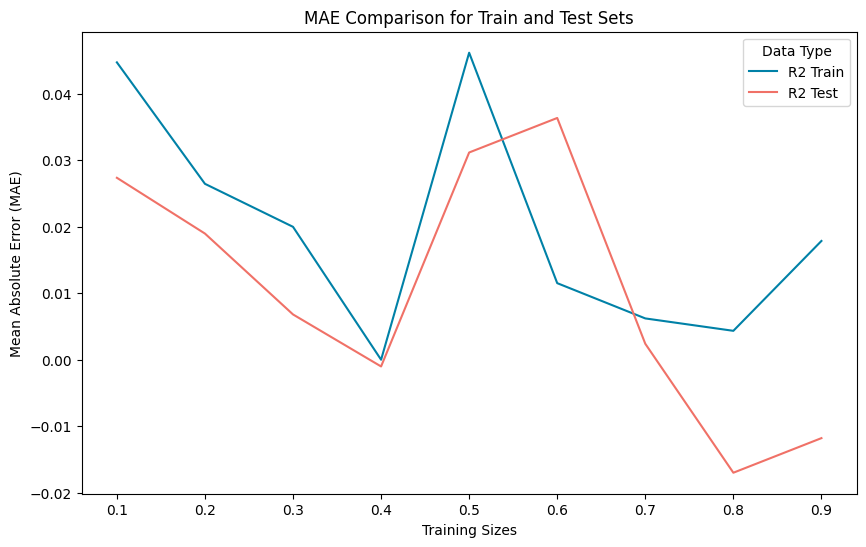

In [41]:
plt.figure(figsize=(10, 6))

# Plot the training MAE
sns.lineplot(data=results, x="Train Sizes", y="R2 Train", label="R2 Train", color="#0081a7")

# Plot the testing MAE
sns.lineplot(data=results, x="Train Sizes", y="R2 Test", label="R2 Test", color="#f07167")

# Adding some plot details
plt.title("R2 Comparison for Train and Test Sets")
plt.ylabel("R2")
plt.xlabel("Training Sizes")
plt.legend(title="Data Type")

# Show the plot
plt.show()



In [39]:
train_scores

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])